<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Figure-9.1a" data-toc-modified-id="Figure-9.1a-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 9.1a</a></span></li><li><span><a href="#Figure-9.1b" data-toc-modified-id="Figure-9.1b-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 9.1b</a></span></li><li><span><a href="#Figure-9.2" data-toc-modified-id="Figure-9.2-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Figure 9.2</a></span></li><li><span><a href="#Figure-9.3" data-toc-modified-id="Figure-9.3-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Figure 9.3</a></span></li><li><span><a href="#Figure-9.4" data-toc-modified-id="Figure-9.4-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Figure 9.4</a></span></li><li><span><a href="#Figure-9.5" data-toc-modified-id="Figure-9.5-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Figure 9.5</a></span></li></ul></div>

In [1]:
## Analyzing Neural Time Series Data
# Python code for Chapter 9
# Yujin Goto (MATLAB original code: Mike X Cohen)
# 
# This code accompanies the book, titled "Analyzing Neural Time Series Data" 
# (MIT Press). Using the code without following the book may lead to confusion, 
# incorrect data analyses, and misinterpretations of results. 
# Mike X Cohen and Yujin Goto assumes no responsibility for inappropriate or incorrect use of this code. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.signal import firls, filtfilt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import mne

In [3]:
eeg_data = loadmat('./NeuralData/sampleEEGdata.mat')
data = eeg_data["EEG"][0,0]["data"]                 # EEG data (ndarray; ch, times, trial)
pnts = eeg_data["EEG"][0,0]["pnts"][0,0]            # Number of points in EEG data (scalar)
times = eeg_data["EEG"][0,0]["times"][0]            # Time points of data (ndarray)
srate = eeg_data["EEG"][0,0]["srate"][0]            # Sampling rate (ndarray)
trials = eeg_data["EEG"][0,0]["trials"][0,0]        # Trials (scalar)
nbchan = eeg_data["EEG"][0,0]["nbchan"][0,0]        # Number of channel (scalar)

chanlocslabels = eeg_data["EEG"][0,0]["chanlocs"][0]["labels"]

which_channel_to_plot = 'FCz' #specify label of channel to plot
chan_locs_labels=eeg_data["EEG"][0,0]["chanlocs"]["labels"]
channel_index = np.where(chan_locs_labels  == which_channel_to_plot)[1] #specify index (channel number) of label

## Figure 9.1a

<Figure size 1000x600 with 0 Axes>

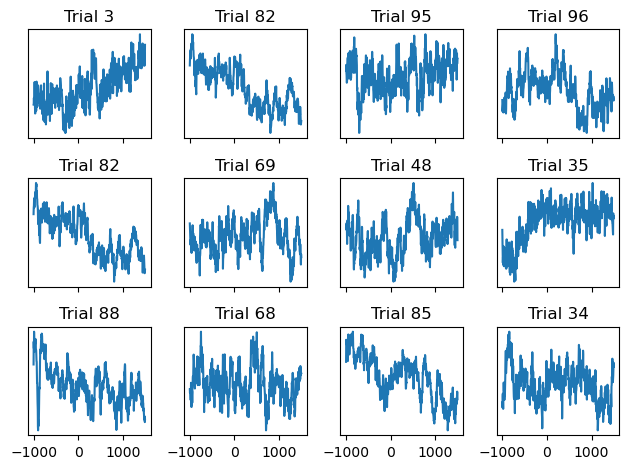

In [4]:
x_axis_limit = (-200, 1000) #in milliseconds

num_trials2plot = 12

plt.figure(figsize=(10, 6))
    
# pick a random trials using random.choice (from numpy.random)
random_trial_to_plot = np.random.choice(np.arange(trials), num_trials2plot)

# figure out how many subplots we need
n_rows = np.ceil(num_trials2plot/np.ceil(np.sqrt(num_trials2plot))).astype(int)
n_cols = np.ceil(np.sqrt(num_trials2plot)).astype(int)
fig, ax = plt.subplots(n_rows, n_cols, sharex='all')

for ii in range(num_trials2plot):
    idx = np.unravel_index(ii, (n_rows, n_cols))

    #plot trial and specify x-axis and title
    ax[idx].plot(times, np.squeeze(data[channel_index,:,random_trial_to_plot[ii] - 1]))
    ax[idx].set(title=f"Trial {random_trial_to_plot[ii]}", yticks=[])

fig.tight_layout()

## Figure 9.1b

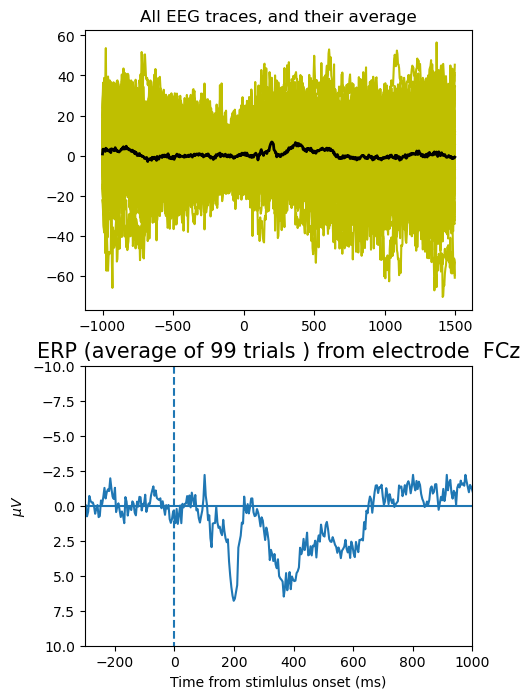

In [5]:
#plot all trials

plt.figure(figsize=(5,8))
plt.subplot(2,1,1)
plt.plot(times,np.squeeze(data[channel_index,:,:]),'y')

#plot the event-related potential (ERP), i.e. the average time-domain signal
plt.plot(times,np.squeeze(np.mean(data[channel_index,:,:],axis=2)),'k',linewidth=2)
plt.title("All EEG traces, and their average")


plt.subplot(2,1,2)
#now plot only the ERP
plt.plot(times,np.squeeze(np.mean(data[channel_index,:,:],axis=2))) #axis=2 specifies which axis to compute the mean along
plt.vlines(0,-10,10,linestyles='dashed')
plt.hlines(0,-1000,1500)

plt.axis([-300,1000,-10,10])
plt.xlabel("Time from stimlulus onset (ms)")
plt.ylabel(r'$ \mu V $') #latex interpreter looks for dollar signs
plt.title(f"ERP (average of {str(trials)} trials ) from electrode  {which_channel_to_plot}", fontsize=15)
plt.gca().invert_yaxis() #EEG convention to flip y axis

## Figure 9.2

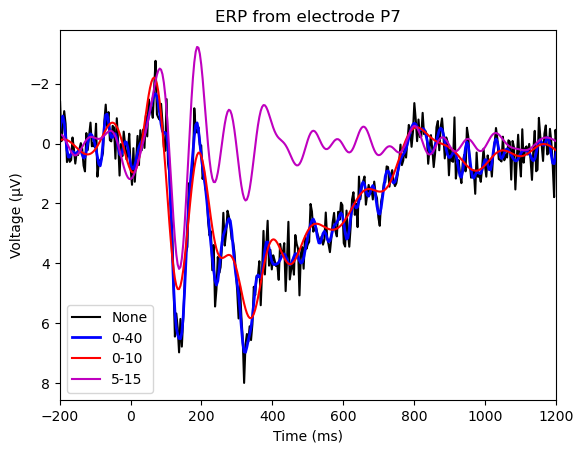

In [6]:
# Pick a channel
chan2plot = 'P7'

# Compute ERP
channel_index = np.where(chan_locs_labels  == chan2plot)[1]
erp = np.mean(data[channel_index, :, :], axis=2).flatten()

# Low-pass filter parameters
nyquist = int(srate) / 2
transition_width = 0.15  # percent

# Filter from 0-40 Hz
filter_cutoff = 40  # Hz
ffrequencies = np.array([0, filter_cutoff, filter_cutoff * (1 + transition_width), nyquist]) / nyquist
idealresponse = [1, 1, 0, 0]
filterweights = firls(101, ffrequencies, idealresponse)
erp_0to40 = filtfilt(filterweights, 1, erp)

# Filter from 0-10 Hz
filter_cutoff = 10  # Hz
ffrequencies = np.array([0, filter_cutoff, filter_cutoff * (1 + transition_width), nyquist]) / nyquist
idealresponse = [1, 1, 0, 0]
filterweights = firls(101, ffrequencies, idealresponse)
erp_0to10 = filtfilt(filterweights, 1, erp)

# Filter from 5-15 Hz
filter_low = 5  # Hz
filter_high = 15  # Hz
ffrequencies = np.array([0, filter_low * (1 - transition_width), filter_low, filter_high, filter_high * (1 + transition_width), nyquist]) / nyquist
idealresponse = [0, 0, 1, 1, 0, 0]
filterweights = firls(np.round(3 * (1+srate / filter_low)), ffrequencies, idealresponse)
erp_5to15 = filtfilt(filterweights, 1, erp)

# Plot all filtered ERPs
plt.figure()
plt.plot(times, erp, 'k', label='None')
plt.plot(times, erp_0to40, 'b', linewidth=2, label='0-40')
plt.plot(times, erp_0to10, 'r', label='0-10')
plt.plot(times, erp_5to15, 'm', label='5-15')

plt.xlim([-200, 1200])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (μV)')
plt.title(f'ERP from electrode {chan2plot}')
plt.legend()
plt.gca().invert_yaxis() #EEG convention to flip y axis

## Figure 9.3

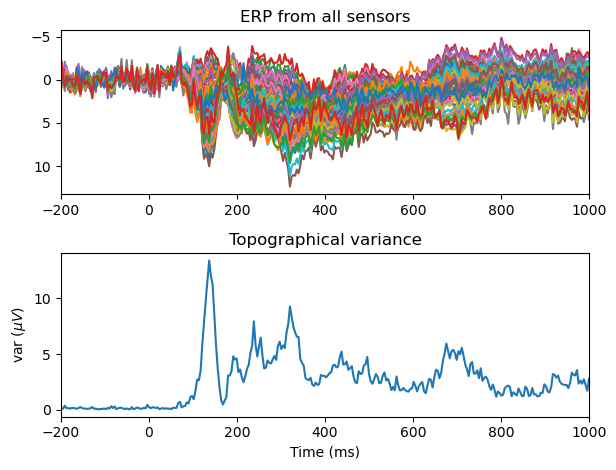

In [7]:
plt.figure()

plt.subplot(2, 1, 1)
plt.plot(times,np.squeeze(data.mean(axis=2)).T)
plt.xlim([-200, 1000])
plt.gca().invert_yaxis() #flip for EEG conventions
plt.title("ERP from all sensors")

#topographical variance plot

plt.subplot(2, 1, 2)
plt.plot(times,np.squeeze(data.mean(axis=2).var(axis=0)))
plt.xlim([-200,1000])
plt.xlabel("Time (ms)")
plt.ylabel("var "+r'$ (\mu V) $')
plt.title("Topographical variance")
plt.tight_layout()

## Figure 9.4

In [8]:
chanlocslabels[0]

array(['Fp1'], dtype='<U3')

In [9]:
# create mne Evoked object

# create channel montage 
EEG = eeg_data['EEG']
chan_labels = [str(label) for label in chan_locs_labels.tolist()[0]]

# Y: right-left, needed to be reversed, X: bottom-top
coords = np.vstack([-EEG[0,0]['chanlocs']['Y'],EEG[0,0]['chanlocs']['X'],EEG[0,0]['chanlocs']['Z']]).T
coords_as_tuples = [tuple(coord) for coord in coords]
ch_pos = {label: coord for label, coord in zip(chan_labels, coords_as_tuples)}
montage = mne.channels.make_dig_montage(ch_pos = dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = mne.create_info(chan_labels, srate, ch_types='eeg')
evoked = mne.EvokedArray(data.mean(axis=2), info, tmin=EEG['xmin'].tolist()[0][0][0][0])
evoked.set_montage(montage);

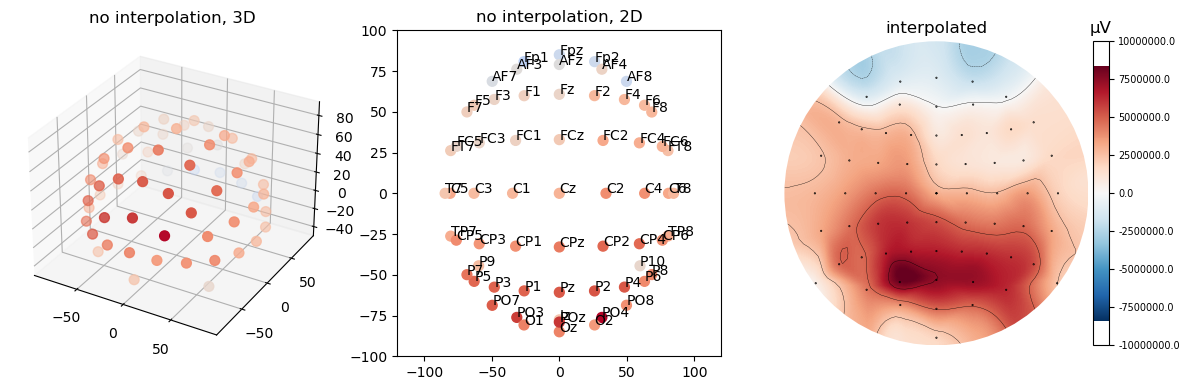

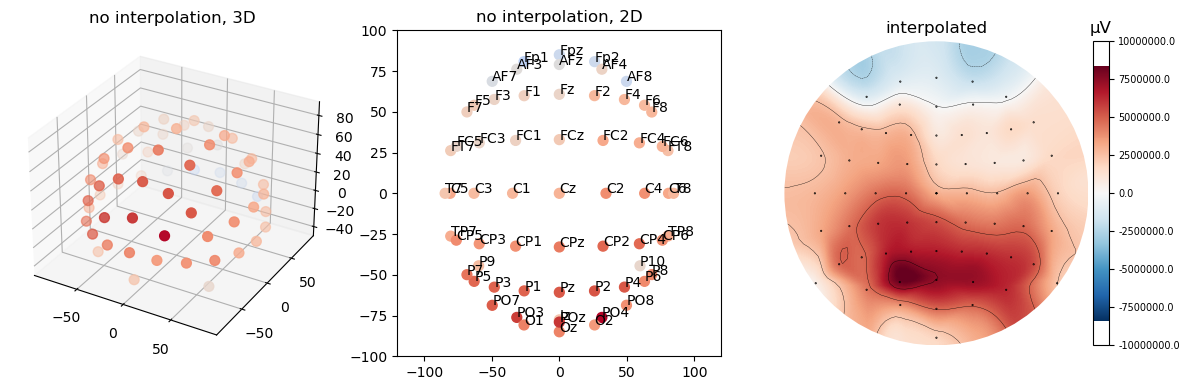

In [10]:
# topoplot with colored dots vs. interpolated surface

# average voltage over trials for a given timepoint
TOI = 300 # ms
c = data.mean(axis=2)[:, np.argmin(abs(times - TOI))]

# create figure
fig = plt.figure(figsize=(12,4), tight_layout=True)

# plot topomap without interpolation, 3D
clim = np.max(np.abs(c))
ax_1 = fig.add_subplot(1, 3, 1, projection='3d')
ax_1.scatter(EEG[0,0]['chanlocs']['Y'].tolist(), EEG[0,0]['chanlocs']['X'].tolist(), EEG[0,0]['chanlocs']['Z'].tolist(), s=50, c=c, cmap='coolwarm', vmin=-clim,vmax=clim)
ax_1.set(title='no interpolation, 3D')

# plot topomap without interpolation
ax_2 = fig.add_subplot(1, 3, 2)
ax_2.scatter(EEG[0,0]['chanlocs']['Y'], EEG[0,0]['chanlocs']['X'], s=50, c=c, cmap='coolwarm', vmin=-clim, vmax=clim)
for i in range(len(chan_labels)):
    ax_2.text(-EEG[0,0]['chanlocs'][0,i]['Y'][0][0], EEG[0,0]['chanlocs'][0,i]['X'][0][0], f"{chan_locs_labels[0,i][0]}", fontsize=10)
ax_2.set(title='no interpolation, 2D')
ax_2.set_xlim([-120,120])
ax_2.set_ylim([-100,100])

# plot interpolated data
# make colorbar axis
ax_3 = fig.add_subplot(1, 3, 3)
divider = make_axes_locatable(ax_3)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax_3.set(title='interpolated')
evoked.plot_topomap(times=TOI/1000, axes=(ax_3, cax), time_format='')

## Figure 9.5

In [11]:
EEG_broken = data.copy()
channel_index = np.where(chan_locs_labels  == 'FC4')[1]
EEG_broken[channel_index] = np.random.randn() * 10

evoked_broken = mne.EvokedArray(EEG_broken.mean(axis=2), info, tmin=EEG['xmin'].tolist()[0][0][0][0])
evoked_broken.set_montage(montage)

<Evoked | '' (average, N=1), -1 – 1.4961 s, baseline off, 64 ch, ~410 kB>

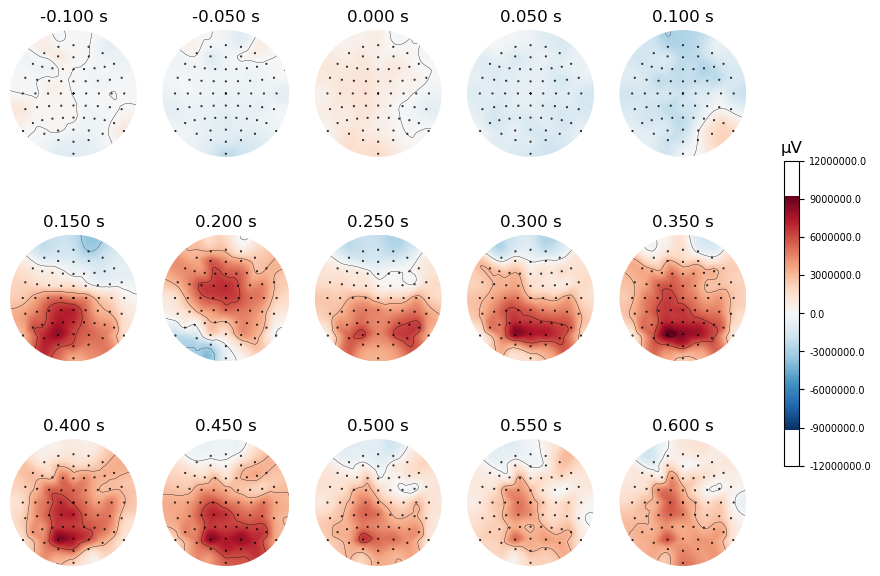

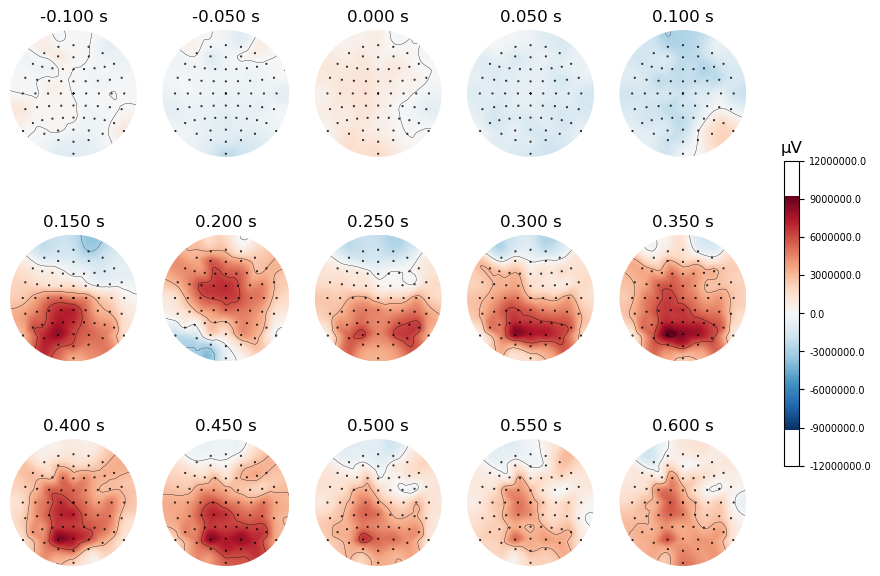

In [12]:
# plot topomap, interpolated surface, 50 ms intervals
evoked.plot_topomap(times=np.linspace(-100,600,15)/1000, nrows=3)

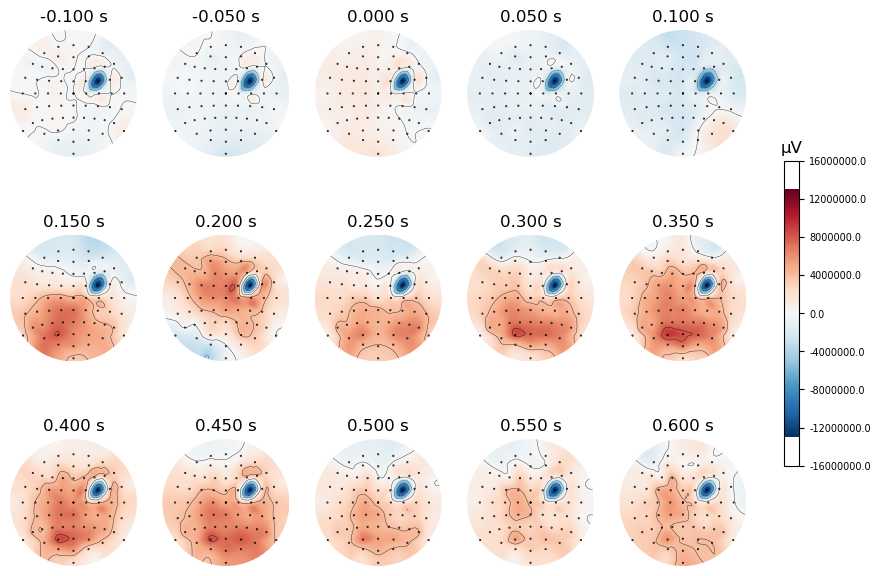

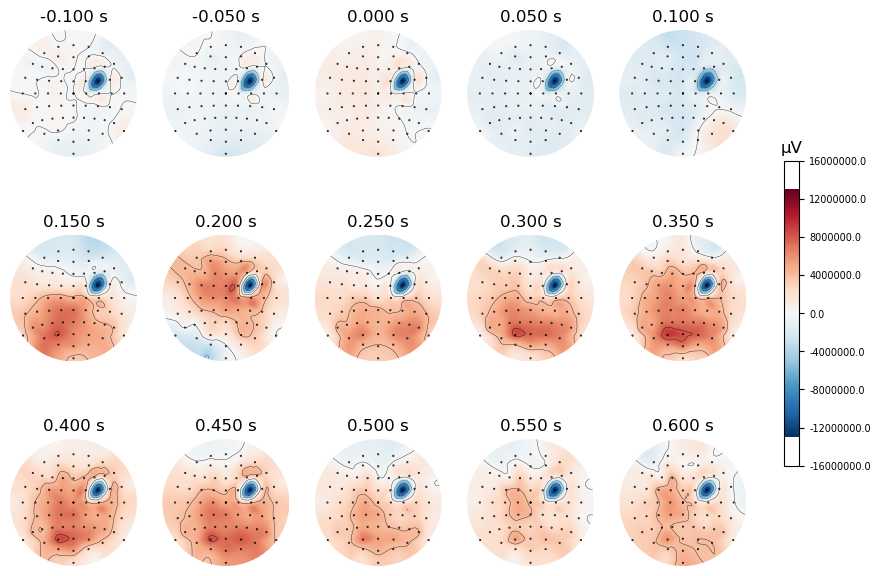

In [13]:
# FC4 broken topomap
evoked_broken.plot_topomap(times=np.linspace(-100,600,15)/1000, nrows=3)